# Clusterização

### Atividade 1: Crie um dataframe a partir do banco de dados `basedosdados.br_inep_ideb.municipio` disponível em [Ideb](https://basedosdados.org/dataset/br-inep-ideb?bdm_table=municipio). Selecione apenas as colunas `ano`, `sigla_uf`, `taxa_aprovacao`, `nota_saeb_matematica`, `nota_saeb_lingua_portuguesa` e `ideb`.

In [99]:
# import libs
import pandas as pd
import numpy as np

#data viz
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import set_config
set_config(transform_output = "pandas")

# Metrics and stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score



In [2]:
# Read and select data
df = pd.read_csv(r'C:\Users\aurel\OneDrive\Documentos\Estudo\Sirius\2 - Estatistica descritiva II\S1D4\Data\ideb.csv', 
                 usecols = ['ano',
                            'sigla_uf',
                            'taxa_aprovacao',
                            'nota_saeb_matematica',
                            'nota_saeb_lingua_portuguesa',
                            'ideb'
                            ])

df.head()

,ano,sigla_uf,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
0,2005,AC,53.9,167.8,165.60,2.3
1,2005,AC,49.3,151.8,149.60,1.8
2,2005,AC,48.8,163.6,155.80,1.9
3,2005,AC,48.8,159.0,153.39,1.9
4,2005,AC,74.7,138.0,134.19,2.3


In [3]:
# Count null values
df.isna().sum()

ano                                0
sigla_uf                           0
taxa_aprovacao                 63593
nota_saeb_matematica           96556
nota_saeb_lingua_portuguesa    96556
ideb                           72381
dtype: int64

In [4]:
# Drop null values
df.dropna(inplace=True)

Removi os valores nulos para evitar problemas futuros na análise. 

### Atividade 2: Selecione apenas os dados referentes ao ano de 2019 e agrupe os dados por estado, considerando a média.

In [5]:
# Slice and group data
df_2019 = df.query('ano == 2019')\
            .groupby('sigla_uf').mean()\
            .reset_index()

df_2019.head()

,sigla_uf,ano,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
0,AC,2019.0,88.857971,245.253478,237.995942,4.671739
1,AL,2019.0,92.258013,237.883189,231.412708,4.509295
2,AM,2019.0,87.171490,223.121965,219.773218,4.032397
3,AP,2019.0,82.363333,217.216667,215.831111,3.694444
4,BA,2019.0,83.492417,233.942537,230.205596,4.034125


### Atividade 3: Padronize os dados.

In [6]:
scaler = StandardScaler()

In [7]:
# create transformed dataframe 
df_2019_scaled = scaler.fit_transform(df_2019.iloc[:,2:])
df_2019_scaled.head()

,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
0,-0.042238,0.080568,-0.016633,0.092154
1,0.792119,-0.437297,-0.532115,-0.201424
2,-0.456094,-1.474477,-1.443512,-1.063297
3,-1.635997,-1.889406,-1.752188,-1.674063
4,-1.358925,-0.714182,-0.626634,-1.060175


### Atividade 4: Use o método do cotovelo para encontrar um valor adequado de k.

In [8]:
# show correlation values
df_2019_scaled.corr()

,taxa_aprovacao,nota_saeb_matematica,nota_saeb_lingua_portuguesa,ideb
taxa_aprovacao,1.000000,0.692981,0.672152,0.823510
nota_saeb_matematica,0.692981,1.000000,0.991216,0.956578
nota_saeb_lingua_portuguesa,0.672152,0.991216,1.000000,0.939014
ideb,0.823510,0.956578,0.939014,1.000000


Decidi por utilizar as variáveis `taxa_aprovacao` e `ideb` pois não apresenta uma correlação linear tão alta quanto aos outros grupos de variáveis, e gerará um gráfico de dispersão menos linear tornando a vizualização dos grupos mais fácil de se interpretar


In [9]:
# Select data to training model
X = df_2019_scaled[['taxa_aprovacao','ideb']].copy()

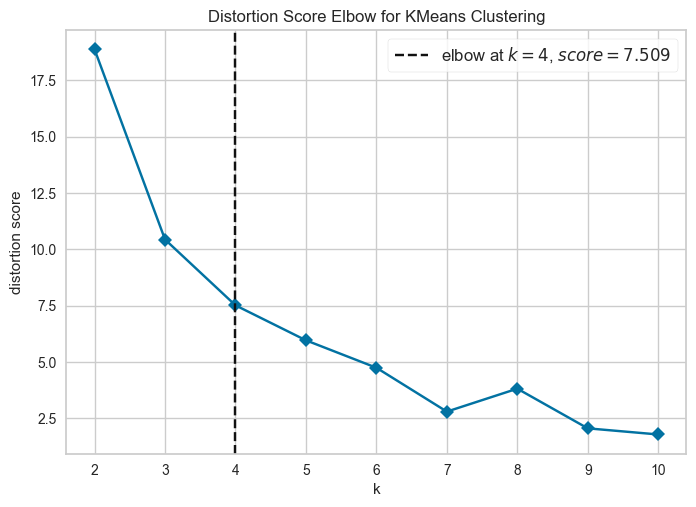

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init='auto',
                                  random_state=50),
                 timings=False)

In [10]:
# kelbow_visualizer plot
kelbow_visualizer(KMeans(n_init = "auto", random_state = 50), X, k=10, timings=False)

* **De acordo com o método do cotovelo o valor de K ideal é 4**

### Atividade 5: Use o método da silhueta para encontrar um valor adequado de k

In [11]:
# Create list of dictionaries
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

# loop to get metrics values
for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=50, n_init = 'auto')
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)
  
# Show metrics in dataframe using style background
pd.DataFrame(cluster_metrics_results)\
  .set_index('k')\
  .style.background_gradient(cmap='mako', subset = 'inertia')\
        .highlight_max(color = 'purple',  subset = ['silhouette_score','calinski_harabasz_score'])\
        .highlight_min(color = 'purple',  subset = 'davies_bouldin_score')

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,18.874085,0.507587,0.662553,46.526647
3,10.432780,0.436530,0.764560,50.111922
4,7.509492,0.411439,0.703964,47.463559
5,5.956068,0.364462,0.778377,44.365108
6,4.737296,0.378857,0.810952,43.675412
7,2.789636,0.438648,0.673583,61.191216
8,3.808301,0.327694,0.796661,35.773070
9,2.046467,0.401003,0.647322,57.120618
10,1.774137,0.364707,0.529547,55.603859


* **A quantidade adequada de clusters de acordo com a métrica Silhouette são 2**

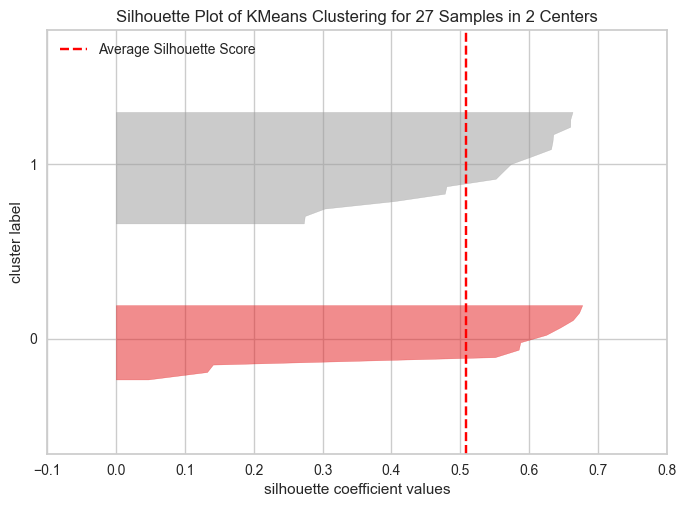

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 27 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=2, n_init='auto',
                                      random_state=50))

In [80]:
# Silhouette plot
silhouette_visualizer(KMeans(n_clusters=2, n_init='auto', random_state = 50), X)

### Atividade 6: Faça a clusterização com o valor escolhido para k.

In [12]:
# Training model with 4 clusters
model = KMeans(n_clusters=4, random_state = 50, n_init = 'auto')
labels = model.fit_predict(X)

# Create data with label
df_cluster = pd.concat([df_2019,pd.DataFrame(labels, columns=['group'])],axis=1)

* **Para a resolução dos exercicios utilizarei 4 clusters que foi o indicado pelo método cotovelo**


### Atividade 7: Faça um gráfico de dispersão destacando cada grupo.

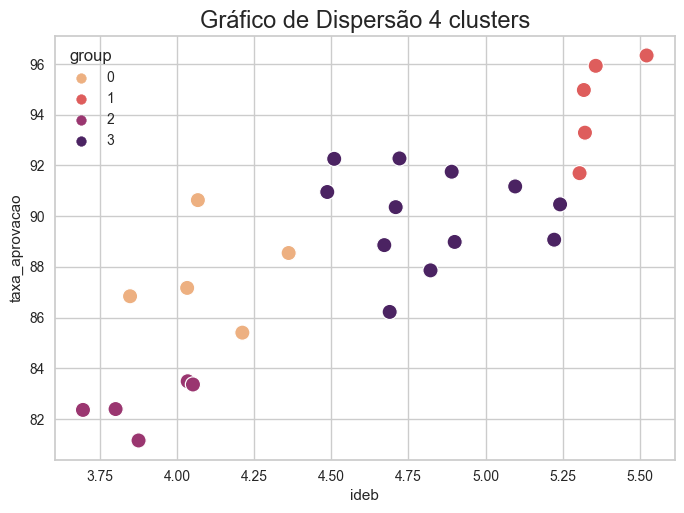

In [13]:
# Scatter plot 4 clusters
ax = sns.scatterplot(data = df_cluster,
                     x = 'ideb',
                     y = 'taxa_aprovacao',
                     hue = 'group',
                     s = 120,
                     palette = 'flare')
ax.set_title(f'Gráfico de Dispersão 4 clusters', fontsize = 17)
plt.show()

### Atividade 8: Quais são os estados de cada grupo?

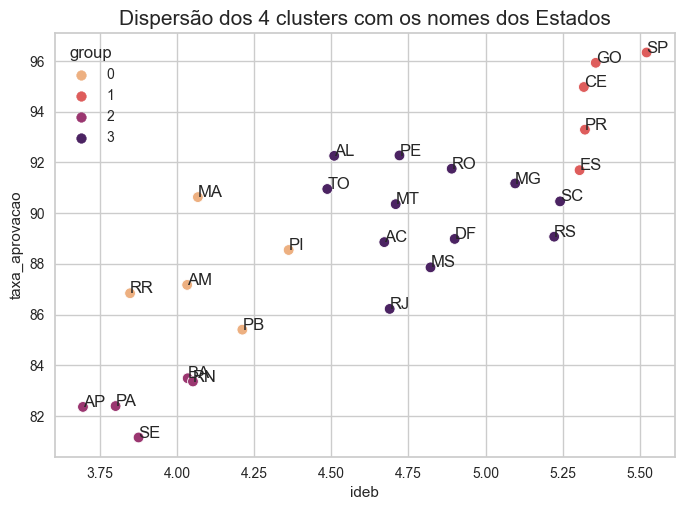

In [14]:
# Scatter plot with named dot
ax = sns.scatterplot(data = df_cluster,
                     x = 'ideb',
                     y = 'taxa_aprovacao',
                     hue = 'group',
                     s = 60,
                     palette = 'flare',);

ideb = x = df_cluster['ideb']
nota = y = df_cluster['taxa_aprovacao']


for i, estado in enumerate(df_cluster.sigla_uf):
    plt.annotate(estado, (ideb[i], nota[i]))


ax.set_title('Dispersão dos 4 clusters com os nomes dos Estados', fontsize =15)
plt.show()

### Atividade 9: Faça um boxplot para comparar os valores das variáveis por grupo.

In [29]:
@interact(col_plot = df_2019.drop(['sigla_uf','ano'], axis = 1).columns.tolist())

def plot_boxplot_interativo(col_plot):
    #plot boxplot
    ax = sns.boxplot(data = df_cluster,
                         x = 'group',
                         y = col_plot,
                         palette = 'flare',
                         showmeans = True)
                         
    ax.set_title(f'Gráfico interativo boxplot - 4 clusters', fontsize = 17)
    ax.set_xlabel('Grupo')
    plt.show()

interactive(children=(Dropdown(description='col_plot', options=('taxa_aprovacao', 'nota_saeb_matematica', 'not…

### Atividade 10: Podemos afirmar, estatisticamente, que os grupos são distintos? Isto é, os dados foram adequadamente clusterizados?

In [30]:
print(pairwise_tukeyhsd(endog = df_cluster.ideb,
                        groups = df_cluster.group,
                        alpha = 0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   1.2613    0.0  0.9016   1.621   True
     0      2   -0.213 0.3778 -0.5727  0.1467  False
     0      3    0.726    0.0  0.4233  1.0287   True
     1      2  -1.4743    0.0  -1.834 -1.1146   True
     1      3  -0.5353 0.0003  -0.838 -0.2326   True
     2      3    0.939    0.0  0.6363  1.2417   True
----------------------------------------------------


* **Estatisticamente sim, os grupos possuem médias distantes entre si utilizando 4 clusters.**
* **Embora o teste tukey apresente que existe um grupo com similiaridade, ressalto que os grupos podem possuir médias semelhantes comparando-as com uma unica variável**

### Atividade 11: Faça a clusterização com outro valor para k.

* **Farei de forma interativa os plots para conseguir avaliar diferentes tipos de grupos**

In [57]:
# get columns names to use in interactive plots
cols = df_2019_scaled.columns.tolist()
cols

['taxa_aprovacao',
 'nota_saeb_matematica',
 'nota_saeb_lingua_portuguesa',
 'ideb']

In [103]:
# interactive plot silhouete (select columns to fit model)
@interact(col_x = cols, 
          col_y = cols)
def silhouette_FataFrame(col_x,col_y):
    # Create list of dictionaries
    cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
    cluster_metrics_results = []

    # Using scaled data to plot
    X = pd.concat([df_2019_scaled[col_x], df_2019_scaled[col_y]], axis = 1)

    # loop to get metrics values
    for k in range(2,11):
      model = KMeans(n_clusters=k, random_state=50, n_init = 'auto')
      labels = model.fit_predict(X)
      cluster_results_dict = {'k': k}
      cluster_results_dict['inertia'] = model.inertia_
      for metric in cluster_metrics:
        cluster_results_dict[metric.__name__] = metric(X, labels)
      cluster_metrics_results.append(cluster_results_dict)
    
    # Show metrics in dataframe using style background
    silhouette = pd.DataFrame(cluster_metrics_results)\
                   .set_index('k')\
                   .style.background_gradient(cmap='mako', subset = 'inertia')\
                         .highlight_max(color = 'cyan',  subset = ['silhouette_score','calinski_harabasz_score'])\
                         .highlight_min(color = 'cyan',  subset = 'davies_bouldin_score')
    plt.show()
    return silhouette

interactive(children=(Dropdown(description='col_x', options=('taxa_aprovacao', 'nota_saeb_matematica', 'nota_s…

In [94]:
# interactive scatterplot (select number of K and cols to predict)
@interact(k = (2,11),
          col_x = cols, 
          col_y = cols)

def plot_cluster(k, col_x, col_y):
    
    # fit model using scaled data
    X = pd.concat([df_2019_scaled[col_x], df_2019_scaled[col_y]], axis = 1)
    model = KMeans(n_clusters=k, random_state = 50, n_init = 'auto')
    labels = model.fit_predict(X)

    #plot scatter
    ax = sns.scatterplot(data = pd.concat([df_2019.drop('sigla_uf', axis = 1), pd.DataFrame(labels)], axis = 1),
                         x = col_x,
                         y = col_y,
                         hue = labels,
                         s = 120,
                         palette = 'flare')
                         
    ax.set_title(f'Gráfico de Dispersão Interativo- {k} clusters', fontsize = 17)
    plt.show()

interactive(children=(IntSlider(value=6, description='k', max=11, min=2), Dropdown(description='col_x', option…

In [95]:
# interactive boxplot (select number of K, cols to predict and plot)

@interact(k = (2,11),
          col_x_predict = cols,
          col_y_predict = cols, 
          col_y_plot = cols)

def plot_cluster(k, col_x_predict,col_y_predict, col_y_plot):
    
    # fit model using scaled data
    X = pd.concat([df_2019_scaled[col_x_predict], df_2019_scaled[col_y_predict]], axis = 1)
    model = KMeans(n_clusters=k, random_state=50, n_init = 'auto')
    labels = model.fit_predict(X)

    #plot boxplot
    ax = sns.boxplot(data = pd.concat([df_2019.drop('sigla_uf', axis = 1), pd.DataFrame(labels)], axis = 1),
                         x = labels,
                         y = col_y_plot,
                         palette = 'flare',
                         showmeans = True)
                         
    ax.set_title(f'Gráfico interativo de boxplot - {k} clusters', fontsize = 17)
    ax.set_xlabel('Grupo')
    plt.show()

interactive(children=(IntSlider(value=6, description='k', max=11, min=2), Dropdown(description='col_x_predict'…

In [104]:
# Count values per group
@interact(k = (2,11),
          col_x_fit = cols,
          col_y_fit = cols)

def quantidade_Elementos(k, col_x_fit,col_y_fit):
    # fit model

    X = pd.concat([df_2019_scaled[col_x_fit],df_2019_scaled[col_y_fit]], axis = 1)
    model = KMeans(n_clusters=k, random_state= 50 , n_init = 'auto')
    labels = model.fit_predict(X)
    df_2019['grupo'] = pd.DataFrame(labels, columns=['grupo'])   
   
    return pd.DataFrame(df_2019.grupo.value_counts())\
             .rename(columns={'count' : 'Quantidade de elementos'})
    

interactive(children=(IntSlider(value=6, description='k', max=11, min=2), Dropdown(description='col_x_fit', op…

### Atividade 12: Qual dos dois valores testados para k seria mais adequado?


* 2 grupos: os grupos possuem muitos elementos, o que pode dificultar a tomada de decisão ou pior, levar a tomada de decisão incorreta aplicando a um dos grupos  esforços ou recursos incorretos para resolução do problema apresentado.
* Mais do que 4 grupos: Existem grupos com poucos elementos, neste caso o melhor seria englobar este pequeno grupo a um grupo com caracteristicas similares.

* **Julgo que o valor de k ideal é de 3 clusters, pois os grupos possuem quantidades semelhantes de elementos e também estão dispersamente separados, facilitando a tomada de decisão para cada grupos.**


### Atividade 13: (Para refletir) Como poderíamos fazer a clusterização e visualizar os grupos se tivessemos que usar mais de duas variáveis?

Dica: Pesquise sobre Redução de Dimensionalidade, é um assunto bem divertido!

Para efetuar a clusterização com mais de 2 variáveis é necessario utilizar um método de redução de dimensionalidade como o PCA, diminuindo a quantidade de colunas e eliminando colunas altamente correlacionadas.
Também poderiamos vizualizar a dispersão dos grupos em um gráfico 3d.

In [105]:
# Training model using 3 features
X = df_2019_scaled.drop('nota_saeb_lingua_portuguesa', axis = 1)
model = KMeans(n_clusters=4, random_state=50, n_init = 'auto')
labels = model.fit_predict(X) 

# Plot 3d scatterplot
px.scatter_3d(df_2019.drop('nota_saeb_lingua_portuguesa', axis = 1), 
                x='taxa_aprovacao', 
                y='ideb', 
                z='nota_saeb_matematica', 
                color=labels, 
                template='plotly_dark')

Removendo a variável `nota_saeb_lingua_portuguesa` e treinando o modelo com as demais variávels continuas obteve-se o resultado do gráfico acima considerando-se o numero de 3 clusters para treino.

* **É necessário aváliar previamente se os dados possuem alta correlação linear, o que pode indicar que as váriaveis podem representar o mesmo valor**